In [7]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize

/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:6554: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:6478: RuntimeWarning: overflow encountered in exp
  return np.exp(s * random_state.standard_normal(size))
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


Distribusi terbaik berdasarkan uji statistik:
  Distribution   KS Test    AD Test      RMSE
0         norm  0.362755  13.786457  0.505990
4      lognorm  0.408268        inf  0.818535
7     invgamma  0.487586        inf  1.307670
8     invgauss  0.501745        inf  1.307670
5   genextreme  0.518193        inf  1.307670
2        gamma  0.629984        inf  0.813975
3  weibull_min  0.630000        inf  0.422494
9         fisk  0.630000        inf  1.415846
6         beta  0.630000        inf  0.304426
1        expon  0.630000        inf  0.529295


<ipython-input-13-eaea6f0eb522>:97: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(zero_inflated_lognorm_pmf(data, s, loc, scale, psi)))
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


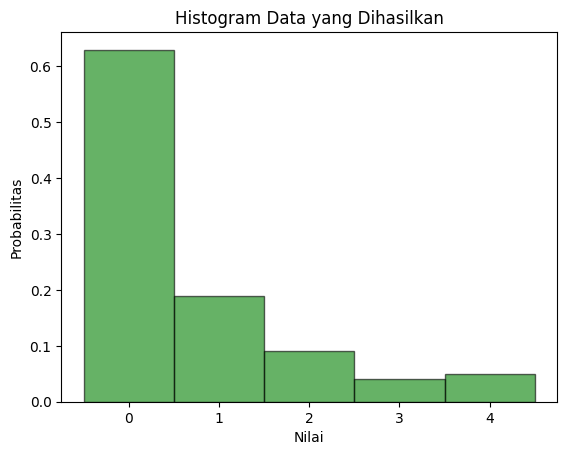

In [13]:
# Set seed agar hasil random konsisten
np.random.seed(42)

# Membuat dataset berdasarkan probabilitas yang diberikan
values = [0, 1, 2, 3, 4]
probabilities = [0.6, 0.2, 0.1, 0.05, 0.05]
data = np.random.choice(values, size=100, p=probabilities)

# Daftar distribusi yang akan diuji
continuous_distributions = [
    stats.norm, stats.expon, stats.gamma, stats.weibull_min, stats.lognorm,
    stats.genextreme, stats.beta, stats.invgamma, stats.invgauss, stats.fisk
]
discrete_distributions = [stats.binom, stats.poisson, stats.nbinom]

# Fungsi untuk Zero Inflated Poisson
def zero_inflated_poisson_pmf(k, lam, psi):
    return np.where(k == 0, psi + (1 - psi) * stats.poisson.pmf(k, lam), (1 - psi) * stats.poisson.pmf(k, lam))

# Fungsi untuk Zero Inflated Negative Binomial
def zero_inflated_nbinom_pmf(k, r, p, psi):
    return np.where(k == 0, psi + (1 - psi) * stats.nbinom.pmf(k, r, p), (1 - psi) * stats.nbinom.pmf(k, r, p))

# Fungsi untuk Zero Inflated Log Normal
def zero_inflated_lognorm_pmf(k, s, loc, scale, psi):
    return np.where(k == 0, psi + (1 - psi) * stats.lognorm.pdf(k, s, loc, scale), (1 - psi) * stats.lognorm.pdf(k, s, loc, scale))

# Evaluasi distribusi kontinu dengan AD-Test, KS-Test, dan RMSE
def evaluate_continuous_distribution(data, dist):
    try:
        params = dist.fit(data)
        if any(np.isnan(params)) or any(np.isinf(params)):
            return None  # Lewati distribusi jika parameter tidak valid

        fitted_data = dist.rvs(*params, size=len(data))
        fitted_data = np.clip(fitted_data, np.min(data), np.max(data))  # Batasi rentang nilai

        ks_statistic, _ = stats.kstest(data, dist.cdf, args=params)
        try:
            ad_result = stats.anderson(data, dist.name)
            ad_statistic = ad_result.statistic if hasattr(ad_result, 'statistic') else np.inf
        except Exception:
            ad_statistic = np.inf

        rmse = np.sqrt(np.mean((np.sort(data) - np.sort(fitted_data))**2))
        return (dist.name, ks_statistic, ad_statistic, rmse)
    except Exception:
        return None

# Evaluasi distribusi diskrit dengan Chi-Square Test, KS-Test, dan RMSE
def evaluate_discrete_distribution(data, dist):
    try:
        observed_freq = np.bincount(data, minlength=5)
        total_samples = len(data)

        if dist == stats.binom:
            n = max(data) + 1
            p = np.mean(data) / n if n > 0 else 0.5
            expected_freq = [total_samples * stats.binom.pmf(k, n, p) for k in range(5)]
        elif dist == stats.poisson:
            lam = max(np.mean(data), 1e-2)
            expected_freq = [total_samples * stats.poisson.pmf(k, lam) for k in range(5)]
        elif dist == stats.nbinom:
            r = 1
            p = np.mean(data) / (np.mean(data) + r)
            expected_freq = [total_samples * stats.nbinom.pmf(k, r, p) for k in range(5)]
        else:
            return None

        expected_freq = np.maximum(expected_freq, 1e-2)  # Hindari nol dalam ekspektasi
        chi_stat, _ = stats.chisquare(observed_freq, expected_freq)
        ks_statistic, _ = stats.kstest(observed_freq, lambda x: sum(expected_freq[:int(x)]) / sum(expected_freq))
        rmse = np.sqrt(np.mean((observed_freq - expected_freq) ** 2))

        return (dist.name, chi_stat, ks_statistic, rmse)
    except Exception:
        return None

# Evaluasi Zero Inflated Distributions
def evaluate_zero_inflated_distribution(data, dist_name):
    try:
        if dist_name == 'Zero Inflated Poisson':
            def objective(params):
                lam, psi = params
                return -np.sum(np.log(zero_inflated_poisson_pmf(data, lam, psi)))
            initial_guess = [np.mean(data), 0.5]
            bounds = [(0, None), (0, 1)]
        elif dist_name == 'Zero Inflated Negative Binomial':
            def objective(params):
                r, p, psi = params
                return -np.sum(np.log(zero_inflated_nbinom_pmf(data, r, p, psi)))
            initial_guess = [1, 0.5, 0.5]
            bounds = [(0, None), (0, 1), (0, 1)]
        elif dist_name == 'Zero Inflated Log Normal':
            def objective(params):
                s, loc, scale, psi = params
                return -np.sum(np.log(zero_inflated_lognorm_pmf(data, s, loc, scale, psi)))
            initial_guess = [1, 0, 1, 0.5]
            bounds = [(0, None), (None, None), (0, None), (0, 1)]
        else:
            return None

        result = minimize(objective, initial_guess, bounds=bounds)
        if not result.success:
            return None

        params = result.x
        if dist_name == 'Zero Inflated Poisson':
            expected_freq = [len(data) * zero_inflated_poisson_pmf(k, *params) for k in range(5)]
        elif dist_name == 'Zero Inflated Negative Binomial':
            expected_freq = [len(data) * zero_inflated_nbinom_pmf(k, *params) for k in range(5)]
        elif dist_name == 'Zero Inflated Log Normal':
            expected_freq = [len(data) * zero_inflated_lognorm_pmf(k, *params) for k in range(5)]

        observed_freq = np.bincount(data, minlength=5)
        expected_freq = np.maximum(expected_freq, 1e-2)
        chi_stat, _ = stats.chisquare(observed_freq, expected_freq)
        ks_statistic, _ = stats.kstest(observed_freq, lambda x: sum(expected_freq[:int(x)]) / sum(expected_freq))
        rmse = np.sqrt(np.mean((observed_freq - expected_freq) ** 2))

        return (dist_name, chi_stat, ks_statistic, rmse)
    except Exception:
        return None

# Menentukan best fit distribution dengan membandingkan hasil uji statistik
results_continuous = [evaluate_continuous_distribution(data, dist) for dist in continuous_distributions]
results_continuous = [res for res in results_continuous if res is not None]

results_discrete = [evaluate_discrete_distribution(data, dist) for dist in discrete_distributions]
results_discrete = [res for res in results_discrete if res is not None]

zero_inflated_distributions = ['Zero Inflated Poisson', 'Zero Inflated Negative Binomial', 'Zero Inflated Log Normal']
results_zero_inflated = [evaluate_zero_inflated_distribution(data, dist) for dist in zero_inflated_distributions]
results_zero_inflated = [res for res in results_zero_inflated if res is not None]

# Hasil evaluasi berdasarkan kesesuaian terbaik
results_df = pd.DataFrame(results_continuous + results_discrete + results_zero_inflated,
                          columns=['Distribution', 'KS Test', 'AD Test', 'RMSE'])

# Sorting dilakukan tanpa mengganti nilai asli
results_df = results_df.sort_values(by=['KS Test', 'AD Test', 'RMSE'], na_position='last')

# Print hasil
print("Distribusi terbaik berdasarkan uji statistik:")
print(results_df)

# Histogram
plt.hist(data, bins=np.arange(-0.5, 5.5, 1), density=True, alpha=0.6, color='g', edgecolor='black')
plt.xlabel('Nilai')
plt.ylabel('Probabilitas')
plt.title('Histogram Data yang Dihasilkan')
plt.xticks(range(5))
plt.show()